In this notebook we scan over a point source with an asymmetric beam to see whether all the angle conventions are consistent.

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import healpy as hp
from beamconv import ScanStrategy
from beamconv import Instrument
from beamconv import Beam
from beamconv import tools
from warnings import catch_warnings, filterwarnings

Create a point source ($I = Q$, $U=0$) and compute the spherical harmonic coefficients. We normalize the coefficients such the corresponding map integrates to one.

In [2]:
nside = 1024
pointmap = np.zeros((3, 12 * nside ** 2))
pointmap[:2,hp.ang2pix(nside, np.pi / 4., np.pi / 3.)] = 1
alm = hp.map2alm(pointmap, lmax=800)
# determine normalization (we want a delta function so a_00 has to be 1/sqrt(4pi))
alm /= (alm[0][0] * np.sqrt(4 * np.pi))

Initialize a physical optics beam and plot it at the location of the point source. Note that for a fair comparison later, we manually set all the azimuthal modes larger than 5 to zero.

In [3]:
beam_dir = '../tests/test_data/example_blms/'
beam_opts = dict(az=0, 
                 el=0,
                 polang=0,
                 fwhm=38,
                 btype='PO', # Physical optics.
                 lmax=800,
                 mmax=5,
                 symmetric=False,
                 cross_pol=True,
                 po_file=beam_dir+'blm_hp_X1T1R1C8A_800_800.npy')
beam = Beam(**beam_opts)

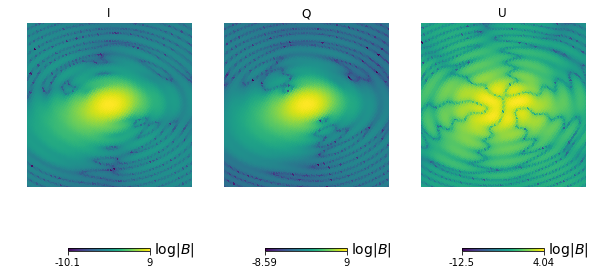

In [4]:
def blm2bmap(blm, nside=1024):
    '''
    Compute pixelized maps of the I, Q and U beams.
    
    Arguments
    ---------
    blm : array-like
        [blm, blmE, blmB]
    
    Keyword arguments
    -----------------
    nside : int
        Nside of output maps
        
    Returns
    -------
    beammaps : array-like
        HEALPix maps of I, Q, U beams.        
    '''
    # We need to divide out sqrt(4pi / (2 ell + 1)) to get 
    # correctly normalized spherical harmonic coeffients.
    ell = np.arange(hp.Alm.getlmax(blm[0].size), dtype=float)
    q_ell = np.sqrt(4. * np.pi / (2 * ell + 1))
    blm = [hp.almxfl(blm[i], 1 / q_ell) for i in range(3)]
    return hp.alm2map(blm, nside, verbose=False)

beam.btype='PO'
blm = np.asarray(beam.blm).copy()

lmax = hp.Alm.getlmax(blm[0].size)
for m in xrange(lmax):
    if m > beam.mmax:
        blm[:,hp.Alm.getidx(lmax, m, m):hp.Alm.getidx(lmax, lmax, m)] = 0

# Convert spin blm to E and B modes.
blm[1:] = tools.spin2eb(*tuple(blm[1:]))
# Rotate to location of point source.
hp.rotate_alm(blm, 0, np.pi/4., np.pi/3.) 

bmaps = blm2bmap(blm, nside=1024)
del(beam.blm)

cart_opts = dict(lonra=[57,63], latra=[42, 48],# min=-10, max=0,
                 hold=True, unit=r'$\log |B|$ ')

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 14))
for pidx, pol in enumerate(['I', 'Q', 'U']):
    plt.axes(axs[pidx])
    hp.cartview(np.log(np.abs(bmaps[pidx])), title=pol, **cart_opts)


We scan over the point source for a day and include a fast spinning half-wave plate to gather enough angular information to produce polarization maps for our single detector. The HWP also helps with decoupling the $I$ and $P$ signal.

In [5]:
instr_opts = dict(lat=89, lon=0) # North pole
scan_opts = dict(duration=24*3600,
                 sample_rate=100)
scan_opts.update(instr_opts)

S = ScanStrategy(**scan_opts)
S.add_to_focal_plane(beam)

In [6]:
S.set_hwp_mod(mode='continuous', freq=1.1)
S.set_el_steps(100, steps=np.linspace(-5, 5, num=100))
const_el_opts = dict(az_throw=10.,
                     scan_speed=50.,
                     az_prf='sawtooth',
                     ra0=60, dec0=45, el_min=-90)

In [7]:
S.add_to_prop(dict(symmetric=False))
S.allocate_maps(nside=1024)
S.scan_instrument_mpi(alm, binning=True, interp=False, save_point=True, save_tod=True, 
                      nside_spin=1024, **const_el_opts)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-8640000


Lets plot a part of the TOD to make sure we are hitting the point source and solve for the map.

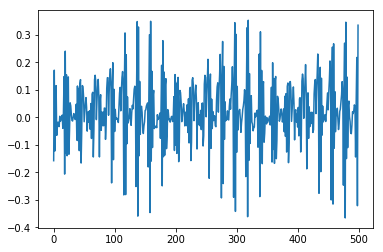

In [8]:
tod = S.data(S.chunks[0], beam, data_type='tod')
plt.plot(tod[:500])

In [9]:
maps, cond = S.solve_for_map(fill=np.nan)

Now we can compare the resulting maps to the beam maps we computed earlier.

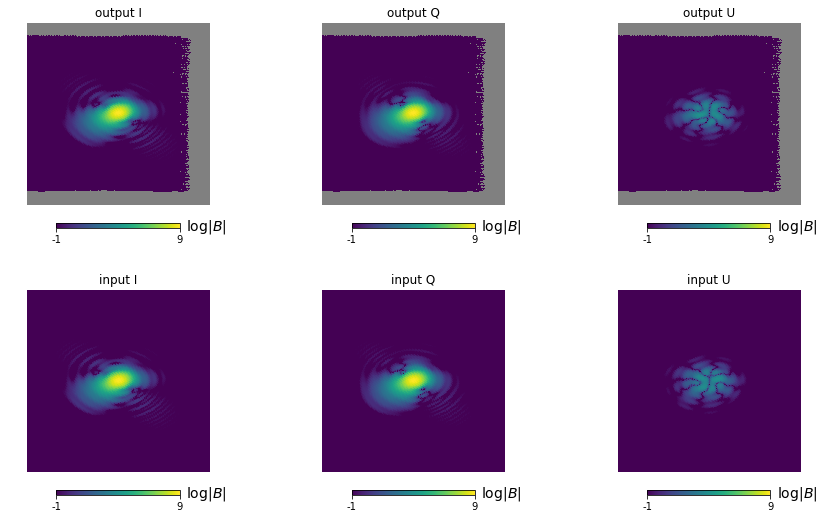

In [10]:
mapsc = maps.copy()

cart_opts = dict(lonra=[54,66],  latra=[39, 51],
                 hold=True, unit=r'$\log |B|$')

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 9))
with catch_warnings():
    filterwarnings('ignore', category=RuntimeWarning)
    for pidx, pol in enumerate(['I', 'Q', 'U']):
        plt.axes(axs[0, pidx])
        hp.cartview(np.log(np.abs(mapsc[pidx])), title='output '+pol, min=-1, max=9, **cart_opts)
        plt.axes(axs[1, pidx])
        hp.cartview(np.log(np.abs(bmaps[pidx])), title='input '+pol, min=-1, max=9, **cart_opts)

Lets also plot the difference between the two and the maps without taking the absolute value.

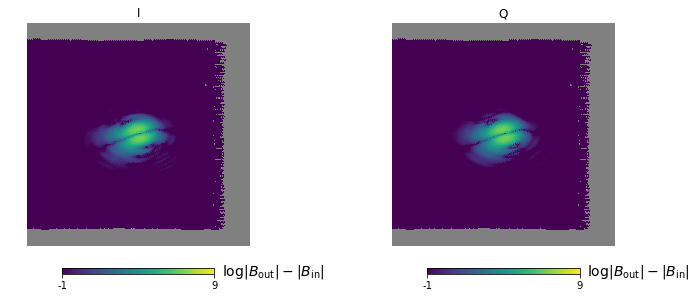

In [11]:
cart_opts = dict(lonra=[54,66],  latra=[39, 51],
                 hold=True, unit=r'$\log |B_{\mathrm{out}}|- |B_{\mathrm{in}}|$')

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
for pidx, pol in enumerate(['I', 'Q']):
    plt.axes(axs[pidx])
    hp.cartview(np.log(np.abs(np.abs(mapsc[pidx]) - np.abs(bmaps[pidx]))), min=-1, max=9, title=pol, **cart_opts)

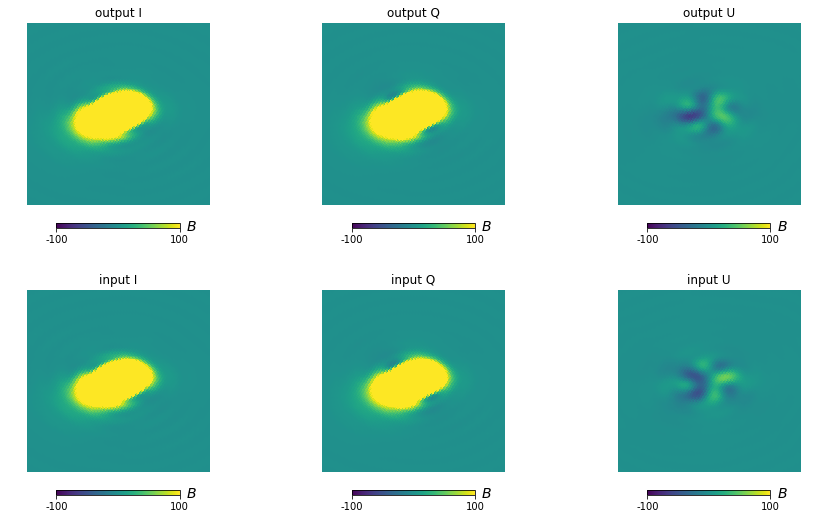

In [12]:
cart_opts = dict(lonra=[57,63],  latra=[42, 48],
                 hold=True, unit=r'$B$')
    
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 9))
for pidx, pol in enumerate(['I', 'Q', 'U']):
    plt.axes(axs[0, pidx])
    hp.cartview(mapsc[pidx], title='output '+pol, min=-1e2, max=1e2, **cart_opts)
    plt.axes(axs[1, pidx])
    hp.cartview(bmaps[pidx], title='input '+pol, min=-1e2, max=1e2, **cart_opts)    